In [9]:
import random
import pandas as pd
import numpy as np
import os
import librosa

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings(action='ignore') 

In [10]:
CFG = {
    'SR':16000,    #sampling rate(16000Hz)
    'N_MFCC':32, # MFCC 벡터를 추출할 개수
    'SEED':41
}

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

In [12]:
train_df = pd.read_csv('./train_data.csv')
test_df = pd.read_csv('./test_data.csv')

In [13]:
def get_mfcc_feature(df, data_type, save_path):
    # Data Folder path
#     root_folder = './wav_dataset'
    import sklearn
    import librosa.display
    root_folder = './'
#     if os.path.exists(save_path):
#         print(f'{save_path} is exist.')
#         return
    features = []
    for uid in tqdm(df['id']):
        root_path = os.path.join(root_folder, data_type)
        path = os.path.join(root_path, str(uid).zfill(5)+'.wav')

        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])
        
        #sklearn 라이브러리 사용해서 전처리 scaling
        mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
        
        #model에 들어갈 input shape을 일정하게 맞춤(최대 9초 정도라 900으로 설정)
        pad = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        padded_mfcc = pad(mfcc, 300)
        
        print(mfcc.shape)
        print(padded_mfcc.shape)
        
        plt.figure()
        librosa.display.specshow(padded_mfcc, sr=16000, x_axis='time')
        plt.title(f'id={uid}')
        plt.show()
        
        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
        #print(features)
    # 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 Feature를 추가
    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1,CFG['N_MFCC']+1)])
    df = pd.concat([df, mfcc_df], axis=1)
    df.to_csv(save_path, index=False)
    print('Done.')

  0%|          | 0/3805 [00:00<?, ?it/s]

(32, 154)
(32, 300)


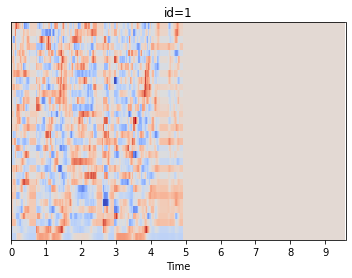

(32, 77)
(32, 300)


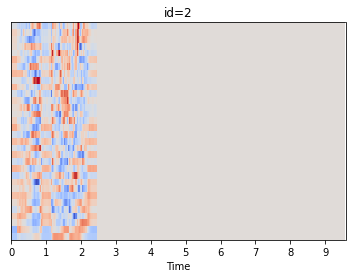

(32, 297)
(32, 300)


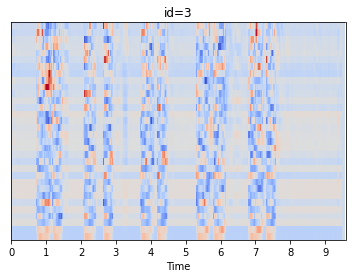

(32, 304)
(32, 300)


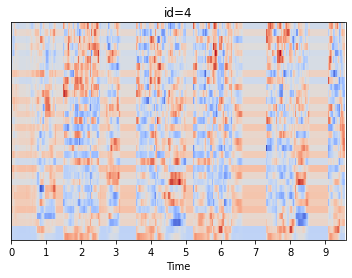

(32, 254)
(32, 300)


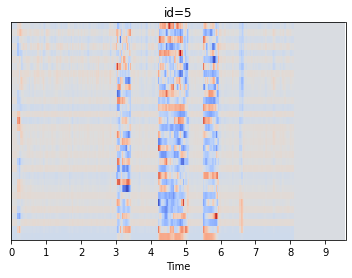

(32, 299)
(32, 300)


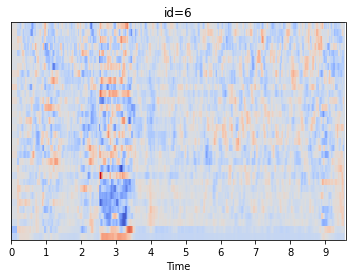

(32, 306)
(32, 300)


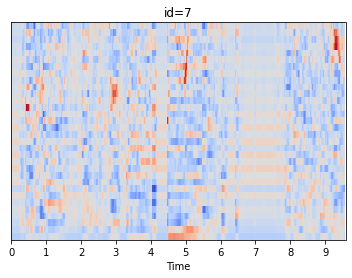

(32, 199)
(32, 300)


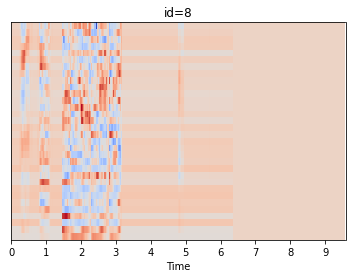

(32, 256)
(32, 300)


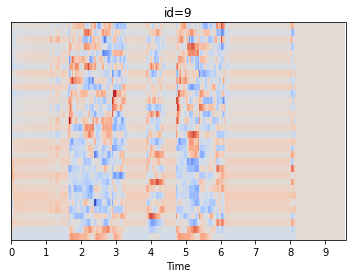

(32, 308)
(32, 300)


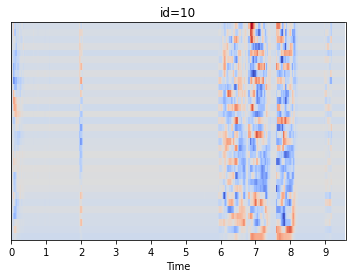

(32, 312)
(32, 300)


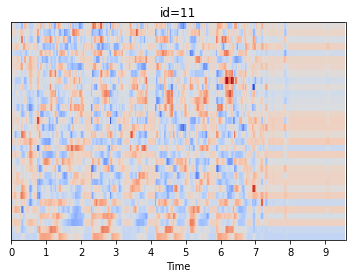

(32, 310)
(32, 300)


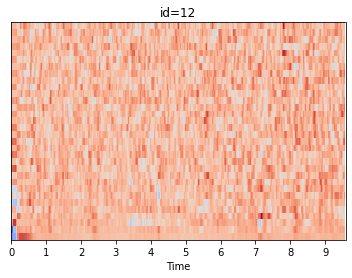

(32, 310)
(32, 300)


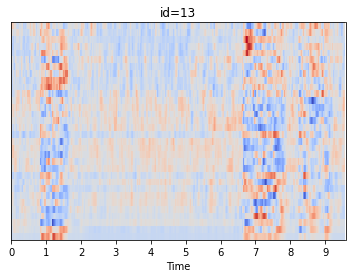

(32, 308)
(32, 300)


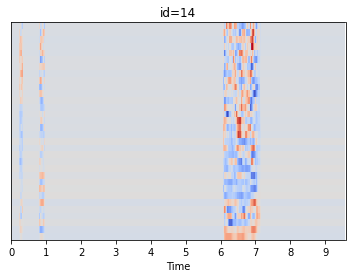

(32, 109)
(32, 300)


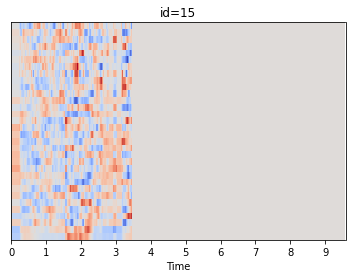

(32, 306)
(32, 300)


KeyboardInterrupt: 

In [14]:
get_mfcc_feature(train_df, 'train', './train_mfcc_data_feature.csv')
get_mfcc_feature(test_df, 'test', './test_mfcc_data_feature.csv')

In [12]:
# wav 파일의 MFCC Feature와 상태정보를 합친 학습데이터를 불러옵니다.
train_df = pd.read_csv('./train_mfcc_data.csv')

# 학습데이터를 모델의 input으로 들어갈 x와 label로 사용할 y로 분할
train_x = train_df.drop(columns=['id', 'covid19'])
train_y = train_df['covid19']

In [13]:
def onehot_encoding(ohe, x):
    # 학습데이터로 부터 fit된 one-hot encoder (ohe)를 받아 transform 시켜주는 함수
    encoded = ohe.transform(x['gender'].values.reshape(-1,1))
    encoded_df = pd.DataFrame(encoded, columns=ohe.categories_[0])
    x = pd.concat([x.drop(columns=['gender']), encoded_df], axis=1)
    return x

In [14]:
# 'gender' column의 경우 추가 전처리가 필요 -> OneHotEncoder 적용
ohe = OneHotEncoder(sparse=False)
ohe.fit(train_x['gender'].values.reshape(-1,1))
train_x = onehot_encoding(ohe, train_x)

In [15]:
model = MLPClassifier(random_state=CFG['SEED']) # Sklearn에서 제공하는 Multi-layer Perceptron classifier 사용
model.fit(train_x, train_y) # Model Train

MLPClassifier(random_state=41)

In [16]:
# 위의 학습데이터를 전처리한 과정과 동일하게 test data에도 적용
test_x = pd.read_csv('./test_mfcc_data.csv')
test_x = test_x.drop(columns=['id'])
# Data Leakage에 유의하여 train data로만 학습된 ohe를 사용
test_x = onehot_encoding(ohe, test_x)

# Model 추론
preds = model.predict(test_x)

In [17]:
submission = pd.read_csv('./sample_submission.csv')
submission['covid19'] = preds
submission.to_csv('./submit1.csv', index=False)